### First attempt sticking grizli output into PostgreSQL tables

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML

import pandas as pd
pd.set_option('display.max_colwidth', -1)

from grizli import utils, __version__
from grizli.aws import db as grizli_db

try:
    from mastquery import overlaps
except:
    overlaps = None
    
print('Grizli version: ', __version__)
utils.set_warnings()

Grizli version:  1.0-35-g23f0390


### postgresql tables on AWS RDS

I've started dumping information into `postgresql` tables and the potential seems awesome, even for my hacky database layout.  

**How does one set this up on TAP / ADQL??**

In [3]:
# readonly DB access
config = {'hostname': 'grizdbinstance.c3prl6czsxrm.us-east-1.rds.amazonaws.com',
 'username': '***',
 'password': '***',
 'database': '***',
 'port': 5432}

# sqlalchemy engine for postgresql
engine = grizli_db.get_db_engine(config=config)
print('Tables: ', engine.table_names())

/Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Tables:  ['xmm_match', 'charge_fields', 'chandra_match', 'z_spec_tmp', 'q_z_tmp', 'xmm_dr8', 'survey_fields', 'observation', 'field_observation', 'photometry_apcorr', 'photometry_detect', 'redshift_fit', 'spec1d_g102_wave', 'spec1d_g141_wave', 'spec1d_g800l_wave', 'spec1d_r30_g800l_wave', 'spec1d_g141', 'spec1d_r30_g141_wave', 'spec1d_r30_g141', 'spec1d_g102', 'spec1d_r30_g102_wave', 'spec1d_r30_g102', 'spec1d_g800l', 'spec1d_r30_g800l', 'highz_2015']


### Redshift fit status flags from the fits run on Lambda

`redshift_fit.status`:

  **`3`** - The object should have an extracted `beams.fits` file in the S3 filesystem

  **`5`** - extractions and redshift fits that timed out in the 15 minute Lambda limit, 
            e.g., some deep pointings or unconstrained fits that find many peaks on the second pass

  **`6`** : completed redshift fits with full information stored in the `redshift_fit` table.


In [4]:
print(grizli_db.FLAGS)

{'init_lambda': 1, 'start_beams': 2, 'done_beams': 3, 'no_run_fit': 4, 'start_redshift_fit': 5, 'fit_complete': 6}


In [5]:
for table in ['charge_fields', 'photometry_apcorr', 'redshift_fit']:
    photom = pd.read_sql_query('select * from {0} where false;'.format(table), engine)
    cols = list(photom.columns)
    count = pd.read_sql_query('select count(*) as n from {0};'.format(table), engine)
    
    print('###  Table `{0}`: {1} rows x {2} columns   ###\n' .format(table, 
                                                    count['n'][0], len(photom.columns)))
    
    r, c = 6, 10
    for i in range(c):
        print('   '+', '.join(['{0:10}'.format(ci) for ci in cols[i*r:(i+1)*r]]))
    print('    ...\n')      

###  Table `charge_fields`: 2502 rows x 377 columns   ###

   qtime     , boxra     , boxdec    , boxrad    , obsquery  , field_root
   field_ra  , field_dec , mw_ebv    , folap     , min_area  , buffer    
   field_xmin, field_xmax, field_ymin, field_ymax, boxquery  , nassoc    
   ecllat    , ecllon    , gallat    , gallon    , nfilt     , filter    
   target    , target_classification, proposal_id, proposal_pi, ng102     , areag102  
   texpg102  , tperg102  , pag102    , ng141     , areag141  , texpg141  
   tperg141  , pag141    , ng800l    , areag800l , texpg800l , tperg800l 
   pag800l   , ng280     , areag280  , texpg280  , tperg280  , pag280    
   mast      , footprint , skip      , has_wfc3ir, comment   , gaia5     
   t_acs_wfc_clear1l_f814w, wh_acs_wfc_clear1l_f814w, a_acs_wfc_clear1l_f814w, t_acs_wfc_f435w, wh_acs_wfc_f435w, a_acs_wfc_f435w
    ...

###  Table `photometry_apcorr`: 2025274 rows x 1302 columns   ###

   thresh    , npix      , tnpix     , image_xmin, image

## Example query: z_grism vs z_spec

Here z_specs are taken from a large variety of literature sources.
I've taken separate tables and matched them into the `photometry_apcorr` database, but 
this would better be done with a separate z_spec table in the database.

The `make_html_table` function below automatically does a join on `redshift_fit` and `photometry_apcorr` based on the object `root` + `id` combinations.

If you don't set `get_sql=True`, it makes a sortable HTML table like the link below sends it to the S3 target specified in `sync`.

### Full table: [HERE](https://s3.amazonaws.com/grizli-v1/tables/zspec_delta.html?&status_min=5.5)

In [6]:
extra = "AND status > 4 AND z_spec > 0 AND z_spec_qual = 1" # AND z_spec_src NOT LIKE '%%Caminha%%'"
extra += "AND (t_g102 > 10 OR t_g141 > 10)"
#extra += "AND (t_g800l > 0)"

SQLtxt = grizli_db.make_html_table(engine=engine, 
                   columns=['root','status','id','ra','dec','mag_auto','flux_radius',
                            't_g800l','t_g102','t_g141',
                            'z_spec','z_map','z_spec_src','bic_diff','chinu','log_pdf_max', 
                            'zwidth1/(1+z_map) as zw1','(z_map-z_spec)/(1+z_spec) as dz','q_z'], 
                   where=extra, 
                   table_root='zspec_delta', sync='s3://grizli-v1/tables/', 
                   png_ext=['R30', 'stack','full','line'], get_sql=True)

print(SQLtxt.replace('FROM','\n    FROM').replace('WHERE','\n    WHERE'))

# Below is like `pd.read_sql_query` but sends result 
# to an astropy table rather than a `DataFrame`
res = grizli_db.from_sql(SQLtxt, engine)
print('N:',len(res))

SELECT root,status,id,ra,dec,mag_auto,flux_radius,t_g800l,t_g102,t_g141,z_spec,z_map,z_spec_src,bic_diff,chinu,log_pdf_max,zwidth1/(1+z_map) as zw1,(z_map-z_spec)/(1+z_spec) as dz,q_z 
    FROM photometry_apcorr, redshift_fit 
    WHERE phot_root = p_root AND id = p_id AND status > 4 AND z_spec > 0 AND z_spec_qual = 1AND (t_g102 > 10 OR t_g141 > 10);
N: 11286


Color by q_z


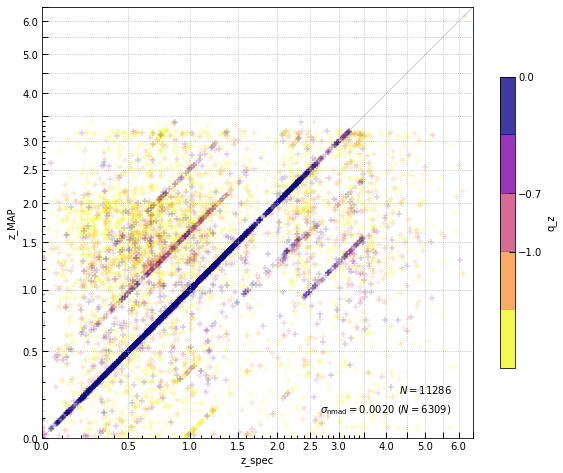

In [7]:
# z_grism vs z_spec
from matplotlib.ticker import FixedLocator, AutoLocator, MaxNLocator
import matplotlib as mpl

# Pseudolog in log(1+z)
xti = xt = np.arange(0,6.6,0.5)
xti = list(xti)
for i in range(len(xti)):
    if (xti[i] > 3) & (xti[i] != int(xti[i])):
        xti[i] = ''

loc = np.arange(0, 3.6, 0.1)

fig = plt.figure(figsize=[8,7])
ax = fig.add_subplot(111)

if False:
    print('Color by zwidth')
    cby = 'zw'
    kwargs = {'marker':'.', 'vmin':-3.5, 'vmax': -0.5, 'cmap': 'plasma'}
    c = np.log10(res['zw1'])
    so = np.argsort(c)[::-1]
else:
    print('Color by q_z')
    cby = 'q_z'
    cmap = plt.cm.plasma_r
    bounds = [-2, -1.5, -1, -0.7, -0.3, 0]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    kwargs = {'marker':'+', 'vmin':-1.5, 'vmax': 0, 'cmap': cmap, 'norm':norm}
    c = res['q_z']
    so = np.argsort(c)
    
ax.scatter(np.log(1+res['z_spec'][so]), np.log(1+res['z_map'][so]), alpha=0.2, 
           c=c[so], **kwargs)

# dummy replot for darker colorbar
sc = ax.scatter(np.log([1]), np.log([1]), alpha=0.8, c=[0], **kwargs)
cb = plt.colorbar(sc, shrink=0.6)

if cby == 'zw':
    cb.set_label(r'$(z_{84}-z_{16})/(1+z_{50})$')
    cb.set_ticks([-3,-2,-1])
    cb.set_ticklabels([0.001, 0.01, 0.1])
elif cby == 'q_z':
    cb.set_label(r'q_z')
    cb.set_ticks([-1, -0.7, 0])
    #cb.set_ticklabels([0.001, 0.01, 0.1])
    
xts = ax.set_xticks(np.log(1+xt))
xtl = ax.set_xticklabels(xti)
xts = ax.set_yticks(np.log(1+xt))
xtl = ax.set_yticklabels(xti)

ax.set_xlim(0, np.log(1+6.5))
ax.set_ylim(0, np.log(1+6.5))

ax.xaxis.set_minor_locator(FixedLocator(np.log(1+loc)))                                                                                                                                          
ax.yaxis.set_minor_locator(FixedLocator(np.log(1+loc)))      

ax.set_xlabel('z_spec')
ax.set_ylabel('z_MAP')

ax.set_aspect(1)
ax.grid()
ax.text(0.95, 0.1, r'$N={0}$'.format(len(res)), ha='right', va='bottom', 
        transform=ax.transAxes)

dz = (res['z_map'] - res['z_spec'])/(1+res['z_spec'])
#sel = (res['z_spec'] > 0) & (np.abs(dz) < 0.1)
#sel = (res['z_spec'] > 0) & (res['zw1'] < 0.05)
sel = (res['z_spec'] > 0) & (res['q_z'] > -1.0)

ax.text(0.95, 0.05, r'$\sigma_\mathrm{{{{nmad}}}}={0:.4f}$ ($N={1}$)'.format(utils.nmad(dz[sel]), sel.sum()), 
        ha='right', va='bottom', transform=ax.transAxes)

ax.plot(ax.get_xlim(), ax.get_xlim(), color='k', 
        alpha=0.2, linewidth=1, zorder=-10)

fig.tight_layout(pad=0.1)

In [8]:
# Count redshift sources
if 0:
    print('z_spec references, in both imaging and spectroscopy')
    SQL = """
    SELECT * FROM (SELECT z_spec_src, count(z_spec_src) AS n FROM photometry_apcorr 
        WHERE z_spec_qual = 1 GROUP BY z_spec_src) foo ORDER BY n DESC;
    """
else:
    # overlap with spectroscopy
    print('z_spec references, overlap with spectroscopy')
    SQL = """
    SELECT * FROM (SELECT z_spec_src, count(z_spec_src) AS n FROM redshift_fit, photometry_apcorr 
        WHERE root = p_root AND id = p_id AND z_spec_qual = 1 GROUP BY z_spec_src) foo ORDER BY n DESC;
    """
counts = grizli_db.from_sql(SQL, engine)
print('N_src={0}, N_tot={1}\n'.format(len(counts), counts['n'].sum()))

nr = 40
msg = '{0:>26}  {1:4}   {2:>26}  {3:4}'
print(msg.format('z_spec_src','n','z_spec_src','n'))
print('='*80)
for i in range(nr):
    print(msg.format(counts['z_spec_src'][i], counts['n'][i], 
                     counts['z_spec_src'][i+nr], counts['n'][i+nr]))
    

z_spec references, overlap with spectroscopy
N_src=106, N_tot=14177

                z_spec_src  n                      z_spec_src  n   
         DEEP3 Cooper 2011  2715                   Stern 2010    40
           Cowie 2004 TKRS  1300              Eisenhardt 2008    40
              MOSDEF v2018  1040               Veron 2006 QSO    34
                 ESO v3 14   714                Carrasco 2017    31
    Urrutia 2018 MUSE-Wide   647                         vvds    29
                    sparcs   642               sdss-dr15-STAR    29
      Inami 2017 MUSE-Deep   618                    deep2-dr4    29
                  ESO v3 1   494                     Ono 2018    28
            Liu 2008 comp.   426                  Kakazu 2007    22
                  ESO v3 0   417                   Sifon 2016    21
  KMOS3D v3 Wisnioski 2019   416                Connelly 2012    18
              Caminha 2017   371                    Ruel 2014    18
                  VUDS DR1   365               

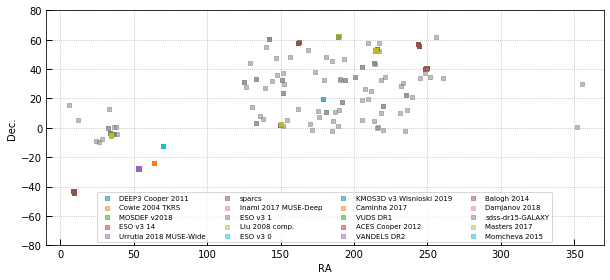

In [9]:
# Show where the sources are on the sky
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)

for src in counts['z_spec_src'][0:20]:
    sub = res['z_spec_src'] == src
    ax.scatter(res['ra'][sub], res['dec'][sub], marker='s', s=20, 
               label=src, alpha=0.5)

ax.set_aspect(1)
ax.set_xlim(-10, 370); ax.set_ylim(-80, 80)
ax.set_xlabel('RA'); ax.set_ylabel('Dec.')
ax.grid()
ax.legend(loc='lower center', fontsize=7, ncol=4)

In [10]:
# Individual object: high-z quasar
where = "AND status > 4 AND z_spec > 6.0 AND z_spec_qual = 1 AND z_spec_src = 'Wang 2016 high-z QSO'"

SQLtxt = grizli_db.make_html_table(engine=engine, 
                                columns=['status','root','id','ra','dec','mag_auto','flux_radius',
                                         'z_spec','z_map','z_spec_src'], 
                                where=where,  get_sql=True)

print(SQLtxt.replace('FROM','\n    FROM').replace('WHERE','\n    WHERE'))

# `from_sql` is like `pd.read_sql_query` but sends result 
# to an astropy table rather than a `DataFrame`
highz = grizli_db.from_sql(SQLtxt, engine)

SELECT status,root,id,ra,dec,mag_auto,flux_radius,z_spec,z_map,z_spec_src 
    FROM photometry_apcorr, redshift_fit 
    WHERE phot_root = p_root AND id = p_id AND status > 4 AND z_spec > 6.0 AND z_spec_qual = 1 AND z_spec_src = 'Wang 2016 high-z QSO';


In [11]:
highz

status,root,id,ra,dec,mag_auto,flux_radius,z_spec,z_map,z_spec_src
int64,str12,int64,float64,float64,float64,float64,float64,float64,str20
6,j142952p5447,719,217.46740,54.78823,20.55,1.2,6.210,6.172,Wang 2016 high-z QSO


In [12]:
HTML(grizli_db.render_for_notebook(highz['root','id','ra','dec','mag_auto','z_spec','z_map'], 
                                   image_extensions=['stack','full']))

,root,id,ra,dec,mag_auto,z_spec,z_map,stack,full
0,j142952p5447,719,217.467397,54.788229,20.549747,6.21,6.17207,,


### 1D spectra in the database!

Every object in the `redshift_fit` table has 1D spectra stored in additional tables `spec1d_g800l`, `spec1d_g102`, and `spec1d_g141`.

The columns of those tables are like:

  - `_flux`: Extracted flux
  - `_err`: Uncertainty
  - `_flat`: Model spectrum for a flat spectrum with flux 1 erg/s/cm2/A used for flux calibration
  - `_contam`: Contamination
  - `_cont`: Best-fit template, continuum only
  - `_line`: Best-fit templates, line **plus** continuum
 
The units of the spectra are the native detector `electrons per second`.  To convert to cgs flux densities, divide by the `_flat` column.

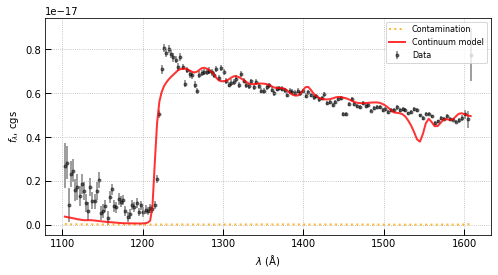

In [13]:
# 1D spectra
tablename = 'spec1d_g102'

SQL = """SELECT root, id, z_map, sp.* from redshift_fit, {1} as sp 
          WHERE root = '{0}' AND id = {2} AND {1}_root = root AND {1}_id = id""".format(highz['root'][0], 
                                                                                        tablename, highz['id'][0])
resp = pd.read_sql_query(SQL, engine)

# Wavelengths stored in a separate table
wave = pd.read_sql_query("SELECT * from {0}_wave".format(tablename), engine)[tablename+'_wave'].values

# Plot the spectra
data = {}
for c in ['flux','err','flat','contam','line','cont']:
    data[c] = np.array(resp['{0}_{1}'.format(tablename, c)][0])

rest_wave = wave / (1+resp['z_map'][0])

fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(111)

er = ax.errorbar(rest_wave, data['flux']/data['flat'], data['err']/data['flat'], 
             marker='.', color='k', linestyle='None', alpha=0.5, label='Data', zorder=-1)

pl = ax.plot(rest_wave, data['contam']/data['flat'], color='orange', linestyle=':', 
              alpha=0.8, linewidth=2, label = 'Contamination')

pl = ax.plot(rest_wave, data['cont']/data['flat'], color='r', 
              alpha=0.8, linewidth=2, label = 'Continuum model')

ax.set_xlabel(r'$\lambda$ ($\mathrm{\AA}$)')
ax.set_ylabel(r'$f_\lambda$, cgs')
ax.legend(loc='upper right', fontsize=8)
ax.grid()

In [14]:
# Quasars
sel = (res['z_spec_src'] == 'sdss-dr15-QSO') | (res['z_spec_src'] == 'Veron 2006 QSO')
sel |= (res['z_spec_src'] == 'KODIAQ')
sel |= np.array(['lqac' in src for src in res['z_spec_src']])
sel |= np.array(['QSO' in src for src in res['z_spec_src']])

print('{0} Quasars from:\n    {1}'.format(sel.sum(), '\n    '.join(np.unique(res['z_spec_src'][sel]))))

# Rigby et al. "MegaSaura" Arc
sel = (res['z_spec_src'] == 'Rigby 2018')
print('\n{0} Megasaura arc images'.format(sel.sum()))

92 Quasars from:
    KODIAQ
    QSO B0117+2118 Simbad
    QSO B0747+4259 Simbad
    QSO B1122-168 Simbad
    QSO B1521+1009 Simbad
    QSO B1630+3744 Simbad
    QSO J1130-1449 Simbad
    Veron 2006 QSO
    Wang 2016 high-z QSO
    lqac_032-000_098
    lqac_148+035_025
    lqac_172+013_045
    lqac_221+029_005
    sdss-dr15-QSO

5 Megasaura arc images


In [15]:
HTML(grizli_db.render_for_notebook(res[sel]['root','id','ra','dec','mag_auto','z_spec','z_map'], 
                                   image_extensions=['stack','full','line']))

,root,id,ra,dec,mag_auto,z_spec,z_map,stack,full,line
0,j032728m1326,1475,51.867475,-13.436768,20.096246,1.703884,1.70493,,,
1,j032728m1326,1467,51.860756,-13.437508,20.120374,1.703850,1.70065,,,
2,j032728m1326,815,51.863205,-13.448375,21.165216,1.703070,1.70306,,,
3,j032728m1326,1477,51.865732,-13.435495,20.994835,1.703600,1.70429,,,
4,j032728m1326,1476,51.866474,-13.435854,20.665002,1.703400,1.70635,,,


### 3D-HST

Spectra in EGS, COSMOS, and UDS have been processed but those fields don't have a full `z_spec` catalog yet.  The field names are a bit different than the `jHHMMSSxDDMMSS` format for the other archival fields.

In [16]:
# G102 + G141
query = '%%-grism%%'

# G800L
#query = '%%-g800l%%'

SQLtxt = """
SELECT status,root,id,p_ra as ra,p_dec as dec,mag_auto,flux_radius,
       t_g800l,t_g141,t_g102,z_spec,z_map,z_spec_src,z_spec_qual,
       bic_diff,zwidth1/(1+z_map) as zw1,
       zwidth2/(1+z_map) as zw2,
       z02,z16,z50,z84,z97
    FROM photometry_apcorr, redshift_fit
WHERE phot_root = p_root AND id = p_id AND status > 4
AND root LIKE '{0}';
""".format(query)

print(SQLtxt)
tab = grizli_db.from_sql(SQLtxt, engine)

fields = np.unique(tab['root'])

print('N total: {0} \nN fields: {1}\n'.format(len(tab), len(fields)))

print('\n'.join(fields))


SELECT status,root,id,p_ra as ra,p_dec as dec,mag_auto,flux_radius,
       t_g800l,t_g141,t_g102,z_spec,z_map,z_spec_src,z_spec_qual,
       bic_diff,zwidth1/(1+z_map) as zw1,
       zwidth2/(1+z_map) as zw2,
       z02,z16,z50,z84,z97
    FROM photometry_apcorr, redshift_fit
WHERE phot_root = p_root AND id = p_id AND status > 4
AND root LIKE '%%-grism%%';

N total: 92756 
N fields: 5

cos-grism-j100012p0210
egs-grism-j141956p5255
gdn-grism-j123656p6215
gds-grism-j033236m2748
uds-grism-j021732m0512


In [17]:
# mag limit
mag_lim = 24
msel = tab['mag_auto'] < mag_lim

# Full photometric catalog
SQLphot = """
SELECT p_root as root, p_ra as ra, p_dec as dec, mag_auto 
       FROM photometry_apcorr
WHERE p_root LIKE '{0}' AND mag_auto < {1} ORDER BY mag_auto;
"""

extra = {}
for field in fields:
    extra[field] = grizli_db.from_sql(SQLphot.format(field.replace('-g800l','-grism'), mag_lim), engine)
    print(field, len(extra[field]))

cos-grism-j100012p0210 18215
egs-grism-j141956p5255 12252
gdn-grism-j123656p6215 7531
gds-grism-j033236m2748 11937
uds-grism-j021732m0512 8563


In [18]:
ct = 'g141'

if ct == 'g800l':
    print('Color on G800l exposure time')
    c = (np.log10(tab['t_g800l']),3,5)
elif ct == 'g141':
    print('Color on G141 exposure time')
    c = (np.log10(tab['t_g141']),3,5)
elif ct == 'g102':
    print('Color on G102 exposure time')
    c = (np.log10(tab['t_g102']),3,5)
else:
    print('Color on redshift fit status (5=timeout, 6=complete)')
    c = (tab['status'],4.5,6.2)

Color on G141 exposure time


field: cos-grism-j100012p0210, n_grism, (< 24) = 17123 (5842), n_full = 18215
field: egs-grism-j141956p5255, n_grism, (< 24) = 22775 (7422), n_full = 12252
field: gdn-grism-j123656p6215, n_grism, (< 24) = 17482 (5570), n_full = 7531
field: gds-grism-j033236m2748, n_grism, (< 24) = 19508 (6101), n_full = 11937
field: uds-grism-j021732m0512, n_grism, (< 24) = 15868 (4689), n_full = 8563


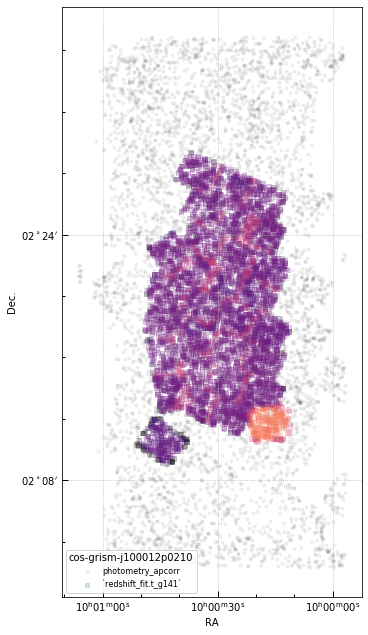

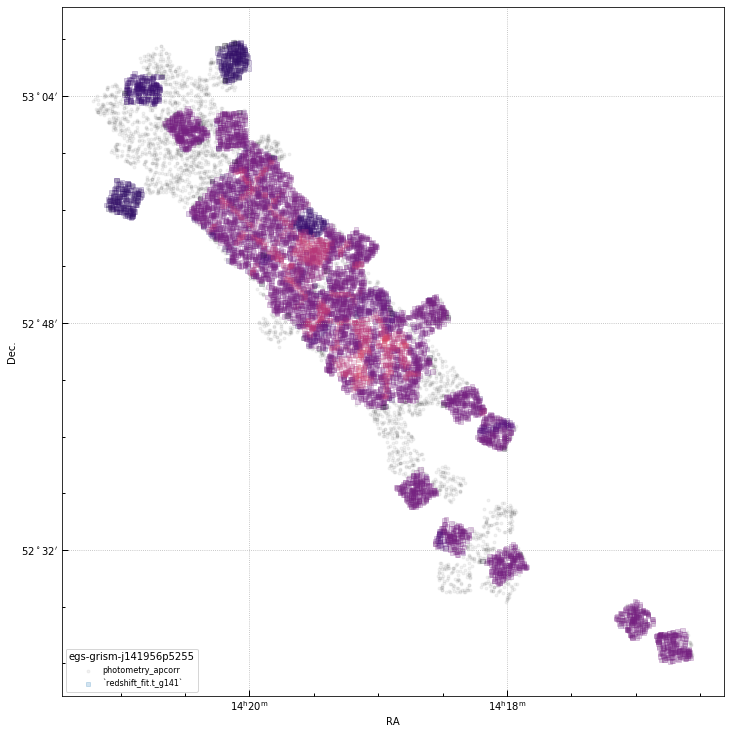

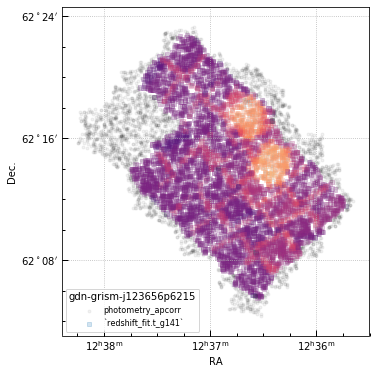

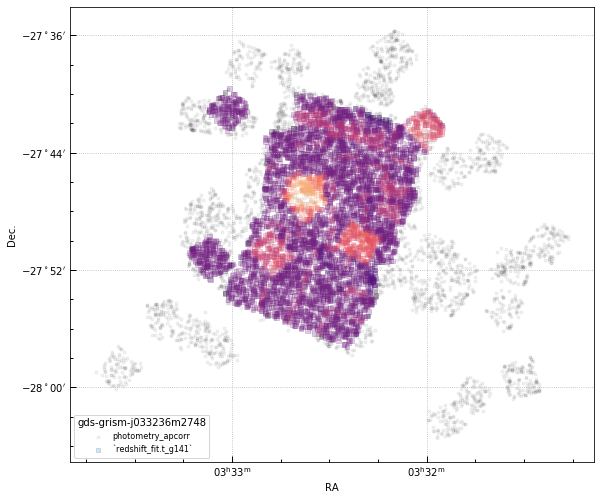

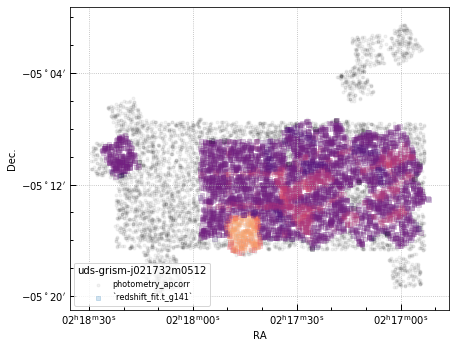

In [19]:
# Show the field layouts

for field in fields:
    fsel = (tab['root'] == field)
    f_i = tab[fsel & msel]
    so = np.argsort(tab['status'][fsel & msel])
    f_i = f_i[so]
    
    # All sources from parent photometry database
    ex = extra[field]
    sk = len(ex)//5000 # skip
    sk = 1 if sk == 0 else sk
    
    msg = 'field: {0}, n_grism, (< {3:.0f}) = {1:4} ({2:4}), n_full = {4:4}'
    print(msg.format(field, fsel.sum(), (fsel & msel).sum(), mag_lim, len(ex)))
    
    dy = (ex['dec'].max()-ex['dec'].min())*60
    dx = (ex['ra'].max()-ex['ra'].min())*60*np.cos(ex['dec'][0]/180*np.pi)
    s = np.clip(5*(np.maximum(dx, dy)/20), 5, 10)

    fig = plt.figure(figsize=[s,s])
    ax = fig.add_subplot(111)
    
    ax.scatter(ex['ra'][::sk], ex['dec'][::sk], marker='.', color='k', 
               alpha=0.05, zorder=-1, label='photometry_apcorr')

    ax.scatter(f_i['ra'], f_i['dec'], c=c[0][fsel & msel][so], alpha=0.2, 
               marker='s', s=20, vmin=c[1], vmax=c[2], cmap='magma', 
               label='`redshift_fit.{0}`'.format(c[0].name))
    
    ax.set_aspect(1./np.cos(f_i['dec'][0]/180*np.pi))
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel('RA'); ax.set_ylabel('Dec.')
    fig.tight_layout(pad=0.2)

    if overlaps is not None:
        overlaps.draw_axis_labels(ax=ax, nlabel=3, format='latex')

    leg = ax.legend(title=field, loc='lower left', fontsize=8)
    
#     ax.text(0.03, 0.03, field, ha='left', va='bottom', 
#             transform=ax.transAxes, fontsize=9, 
#             bbox={'facecolor':'w', 'alpha':0.5, 'edgecolor':'None'})
    
    ax.grid()

### Objects near quasars

Look at some quasar fields selected to be rich absorbers but that also often have excess sources around the quasar itself.

In [20]:
# Get field information from the charge database
pi_names = ['Bielby']

#pi_names = ['Lotz'] # GLASS on FFs

field_query = 'AND (' + 'OR '.join(["proposal_pi LIKE '%%{0}%%'".format(pi) for pi in pi_names]) + ')'

## other test query
# field_query = "AND (field_t_g141 > 4000 AND field_t_g102 > 4000 AND field_t_g141 < 8000"
# field_query += "AND comment = 'WSP' AND gaia5 < 10)"

SQLtxt = """
SELECT root,target,proposal_pi,count(root) as n
    FROM photometry_apcorr, redshift_fit, charge_fields
WHERE phot_root = p_root AND id = p_id AND field_root = p_root AND status > 4 {field_query}
GROUP BY root,target,proposal_pi;
""".format(field_query=field_query)
print(SQLtxt)

parent = grizli_db.from_sql(SQLtxt, engine)
print('N total: {0} \nN fields: {1}'.format(len(parent), len(np.unique(parent['root']))))
parent


SELECT root,target,proposal_pi,count(root) as n
    FROM photometry_apcorr, redshift_fit, charge_fields
WHERE phot_root = p_root AND id = p_id AND field_root = p_root AND status > 4 AND (proposal_pi LIKE '%%Bielby%%')
GROUP BY root,target,proposal_pi;

N total: 12 
N fields: 12


root,target,proposal_pi,n
str12,str26,str26,int64
j012016p2134,PG0117+213,Bielby,498
j023508m0402,HB890232-042 PHL1377,Bielby Lehner,535
j051708m4411,HE0515-4414,Bielby,472
j075056p4252,2MASSIJ0750546+425219,Bielby,394
j081332p2545,HS0810+2554 QSO-B0810+2554,Bielby Kochanek Nierenberg,380
j101956p2744,QSO-J1019+2745,Bielby,439
j112444m1705,2MASSIJ1124428-170517,Bielby,487
j113008m1449,QSO-J1130-1449,Bielby,461
j143748m0147,LBQS-1435-0134,Bielby Mulchaey,604


In [21]:
# Select histogram on grism redshifts, otherwise try to use z_spec
GRISM_HISTOGRAM = False

j012016p2134 Ntot=209 Nmag=183 Nphot=321 n(z_spec)=2
j023508m0402 Ntot=163 Nmag=132 Nphot=361 n(z_spec)=6
j051708m4411 Ntot=206 Nmag=175 Nphot=272 n(z_spec)=1
j075056p4252 Ntot=150 Nmag=131 Nphot=226 n(z_spec)=3
j081332p2545 Ntot=141 Nmag=133 Nphot=328 n(z_spec)=3
j101956p2744 Ntot=204 Nmag=184 Nphot=243 n(z_spec)=1
j112444m1705 Ntot=145 Nmag=135 Nphot=305 n(z_spec)=1
j113008m1449 Ntot=189 Nmag=171 Nphot=276 n(z_spec)=1
j143748m0147 Ntot=241 Nmag=208 Nphot=447 n(z_spec)=3
j152424p0958 Ntot=215 Nmag=182 Nphot=412 n(z_spec)=1


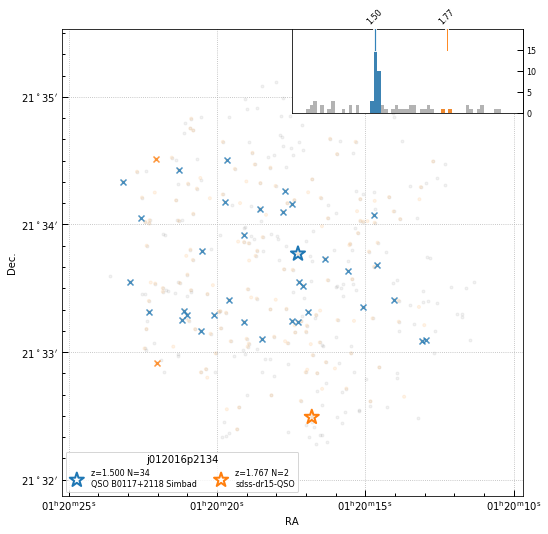

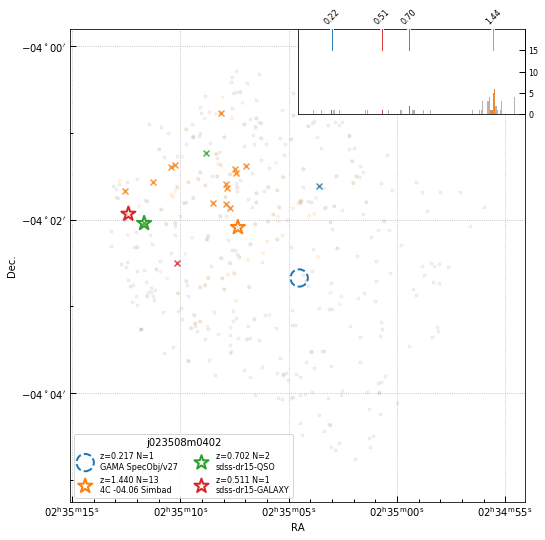

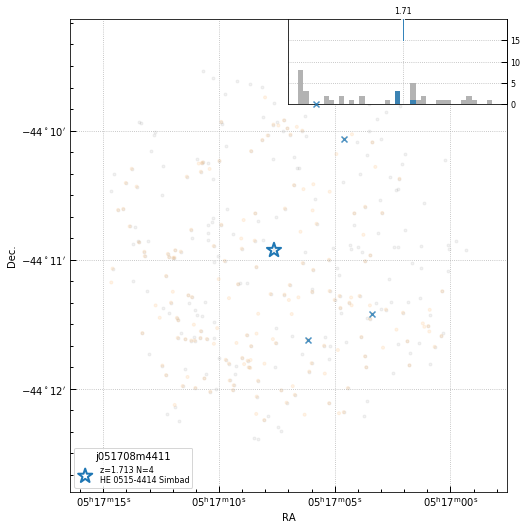

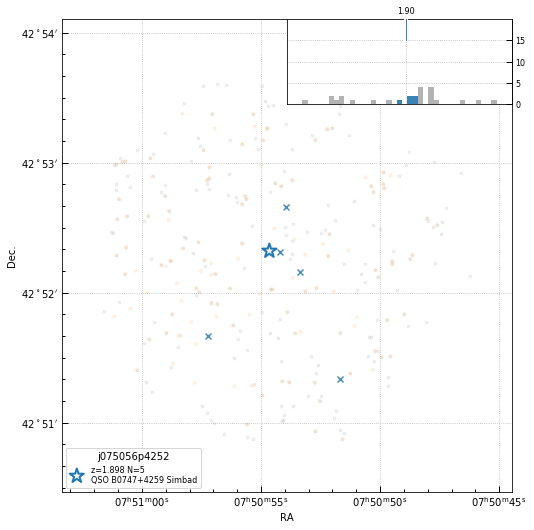

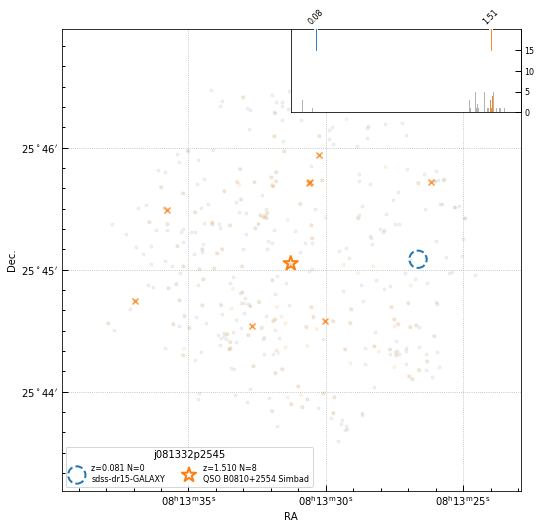

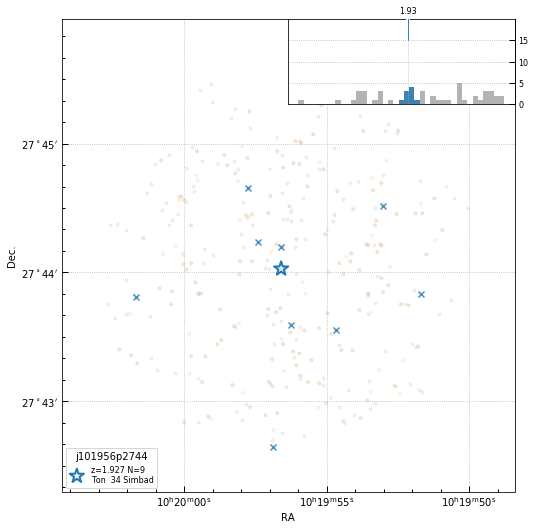

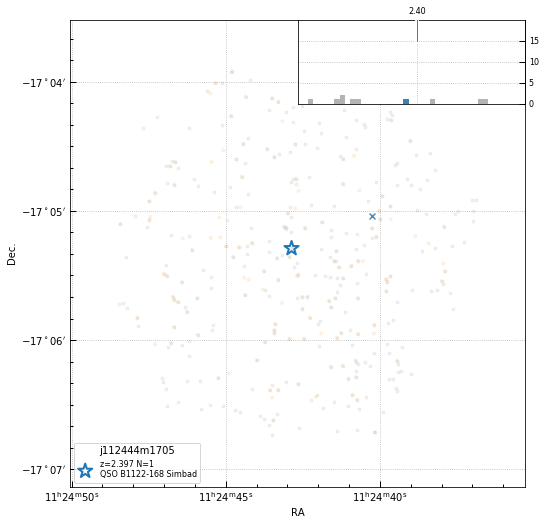

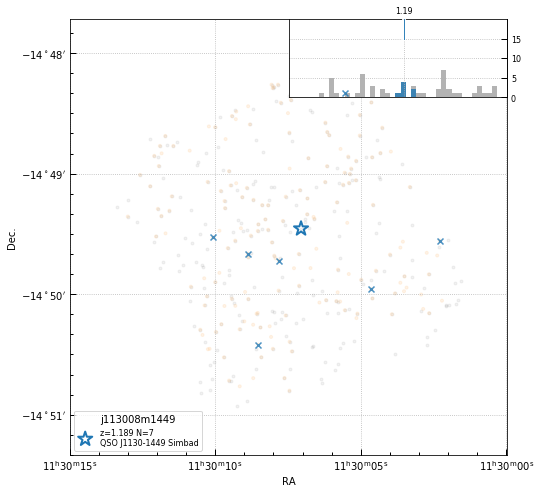

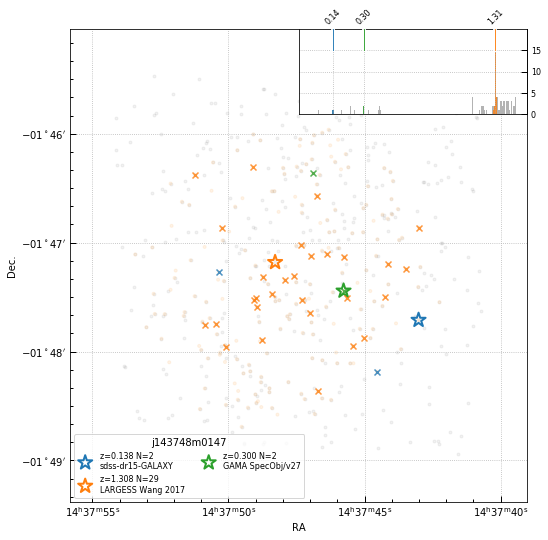

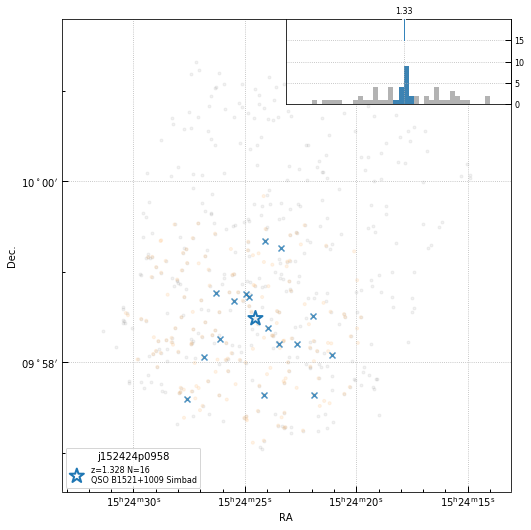

In [22]:
########## Make field layout plots with optional histograms
SQLphot = """
SELECT p_root as root, p_ra as ra, p_dec as dec, mag_auto, z_spec, z_spec_src
       FROM photometry_apcorr
WHERE p_root LIKE '{0}' AND mag_auto < 24 ORDER BY mag_auto;
"""

SQLroot = """
SELECT status,phot_root,root,id,p_ra as ra,p_dec as dec,mag_auto,flux_radius,
       t_g141,t_g102,z_spec,z_map,z_spec_src,z_spec_qual,
       bic_diff,zwidth1/(1+z_map) as zw1,
       zwidth2/(1+z_map) as zw2,
       z02,z16,z50,z84,z97
    FROM photometry_apcorr, redshift_fit
WHERE phot_root = p_root AND id = p_id AND status > 4 AND (root = '{0}') AND q_z > -1.0;"""

fields = np.unique(parent['root'])

# bins for histograms
bins = utils.log_zgrid([0.01, 3.5], 0.005)

# Coarse binning for maxima
spbins = utils.log_zgrid([0.01, 3.5], 0.03)

URL = 'https://s3.amazonaws.com/grizli-v1/Pipeline/{0}/Extractions/{0}.html?&z_map_min={1:.04f}&z_map_max={2:.04f}'
URL += '&bic_diff_min=10&chinu_max=2'

links = []
for field in fields[:10]:
    
    tab = grizli_db.from_sql(SQLroot.format(field), engine)

    msel = tab['mag_auto'] < 25
    #qso = tab['z_spec_src'].filled('---') == 'sdss-dr15-QSO'
    try:
        qso = (tab['z_spec_qual'].filled(0) == 1) #== 'sdss-dr15-QSO'
        qso &= ~utils.column_string_operation(tab['z_spec_src'].filled('---'), 'erb', 'startswith')
    except:
        qso = (tab['z_spec_qual'] == 1) #== 'sdss-dr15-QSO'
        qso &= ~utils.column_string_operation(tab['z_spec_src'], 'erb', 'startswith')
        
    # Color by status
    c = (tab['status'], 4.5, 6.2)
    # Color by grism exposure time
    #c = (np.log10(tab['t_g800l'].filled(1) + tab['t_g141'].filled(1) + tab['t_g102'].filled(1)), 3, 5)
    
    fsel = (tab['root'].filled() == field)
    fq = fsel & qso

    f_i = tab[fsel & msel]
    so = np.argsort(tab['status'][fsel & msel])
    f_i = f_i[so]

    # All sources from parent photometry database
    ex = grizli_db.from_sql(SQLphot.format(tab['phot_root'][0]), engine)
    sk = len(ex)//5000 # skip
    sk = 1 if sk == 0 else sk
    
    # Figure size
    dy = (ex['dec'].max()-ex['dec'].min())*60
    dx = (ex['ra'].max()-ex['ra'].min())*60*np.cos(ex['dec'][0]/180*np.pi)
    s = np.clip(8*(np.maximum(dx, dy)/20), 7, 14)
    fig = plt.figure(figsize=[s,s])
    
    ax = fig.add_subplot(111)
    
    # All sources
    ax.scatter(ex['ra'][::sk], ex['dec'][::sk], marker='.', color='k', 
           alpha=0.05, zorder=-1, label=None)
    
    # grism sources
    ax.scatter(f_i['ra'], f_i['dec'], c=c[0][fsel & msel][so], alpha=0.2, 
               marker='.', vmin=c[1], vmax=c[2], cmap='magma', label=None)
    
    ax.set_aspect(1./np.cos(f_i['dec'][0]/180*np.pi))
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel('RA'); ax.set_ylabel('Dec.')
    fig.tight_layout(pad=0.2)

    #overlaps.draw_axis_labels(ax=ax, nlabel=3, format='latex')
    
    # Quality redshifts
    qual = (f_i['bic_diff'] > 10) | (f_i['zw1'] < 0.02)
    
    # Show 4 redshift peaks
    max_npeak = 3
    
    d1, d2 = 0.5, 0.18
    ax2 = ax.inset_axes((1-d1, 1-d2, d1, d2))
    xt = []

    # Spectroscopic redshifts from parent catalog
    nmin = 1
    zcol = 'z_spec'
    zhist = ex['ra', 'dec', 'z_spec', 'z_spec_src'][ex['z_spec'] > 0]

    if GRISM_HISTOGRAM | (len(zhist) == 0):
        # Grism objects
        fq = fsel & ((tab['bic_diff'] > 10) | (tab['zw1'] < 0.02))
        nmin = 6
        zcol = 'z_map'
        zhist = tab[fq]['ra', 'dec', zcol]


    print('{0} Ntot={1} Nmag={2} Nphot={3} n({4})={5}'.format(field, fsel.sum(), (fsel & msel).sum(),
                              len(ex), zcol, len(zhist)))

    yh, xh = np.histogram(zhist[zcol], bins=spbins)
    bso = np.argsort(yh)[::-1]

    for i, ib in enumerate(bso):
        if (yh[ib] < nmin) | (i > max_npeak):
            break

        ii = (zhist[zcol] >= xh[ib]) & (zhist[zcol] < xh[ib+1])
        zsp = zhist[zcol][ii].mean()

        if zcol == 'z_spec':
            zsrc = '\n'+','.join(list(np.unique(zhist['z_spec_src'][ii])))
        else:
            zsrc = '\nself(grism)'

        plw = ax2.plot([np.log(1+zsp)]*2, [15, 20], color='w', linewidth=4, alpha=0.9, zorder=8)
        pl = ax2.plot([np.log(1+zsp)]*2, [15, 20], linewidth=1, alpha=0.9, zorder=10)
        color_i = pl[0].get_color()

        b_i = np.abs((bins-zsp)/(1+zsp)) < 0.1
        ax2.hist(np.log(1+f_i['z_map'][qual]), bins=np.log(1+bins[b_i]), color='0.7', zorder=-5)
        xt.append(zsp)

        # Plot positions and histogram of objects near the z_spec (QSO) objects
        near = qual & (np.abs((f_i['z_map']-zsp)/(1+zsp)) < 0.01)

        ax2.hist(np.log(1+f_i['z_map'][near]), bins=np.log(1+bins[b_i]), color=color_i, alpha=0.8)

        label = 'z={0:.3f} N={1}{2}'.format(zsp, near.sum(), zsrc)

        dzi = 0.01*(1+zsp)
        URLi = URL.format(field, zsp-dzi, zsp+dzi)
        links.append(HTML('<a href={0}>{1} / {2}</a>'.format(URLi, field, label)))

        if (zcol == 'z_spec') & (ii.sum() == 1):
            ax.scatter(zhist['ra'][ii][:2], zhist['dec'][ii][:2], 
                   edgecolor=color_i, facecolor='None', alpha=1, 
                   s=220, marker='*', zorder=100, linewidth=2,
                   label=label)
        else:
            ax.scatter(zhist['ra'][ii].mean(), zhist['dec'][ii].mean(), 
                   edgecolor=color_i, facecolor='None', alpha=1, 
                   s=300, marker='o', zorder=100, linewidth=2, linestyle='--',
                   label=label)

        ax.scatter(f_i['ra'][near], f_i['dec'][near], marker='x', 
                   color=color_i, alpha=0.8, zorder=1000,
                   label=None)
            
        ax2.set_xticks(np.log(1+np.array(xt))); 
        ax2.set_xticklabels(['{0:.2f}'.format(xti) for xti in xt], rotation=45*(len(xt) > 1))
        ax2.set_ylim(0,20); ax2.set_yticks([0,5,10,15])
        ax2.grid()
        ax2.tick_params(labelsize=8)
        
        ax2.xaxis.set_ticks_position('top')
        ax2.yaxis.set_ticks_position('right')

        ax.legend(loc='lower left', fontsize=8, title=field, ncol=1+(ib > 2)*1)
    else:
        ax.text(0.03, 0.03, field, ha='left', va='bottom', 
            transform=ax.transAxes, fontsize=9, 
            bbox={'facecolor':'w', 'alpha':0.5, 'edgecolor':'None'})

    if overlaps is not None:
        overlaps.draw_axis_labels(ax=ax, nlabel=3, format='latex')

    ax.grid()

# Show URLS
display(*links)

In [23]:
# Fields around SDSS QSOs

# Quasars
# sdss-dr15-QSO
SQLtxt = """
SELECT DISTINCT root
    FROM photometry_apcorr, redshift_fit
WHERE phot_root = p_root AND id = p_id 
      AND (z_spec_src = 'sdss-dr15-QSO' OR z_spec_src = 'LBQS' OR z_spec_src = 'KODIAQ') 
      AND status > 4 AND root LIKE 'j%%';
"""
print(SQLtxt)

parent = grizli_db.from_sql(SQLtxt, engine)
print('N total: {0} \nN fields: {1}'.format(len(parent), len(np.unique(parent['root']))))


SELECT DISTINCT root
    FROM photometry_apcorr, redshift_fit
WHERE phot_root = p_root AND id = p_id 
      AND (z_spec_src = 'sdss-dr15-QSO' OR z_spec_src = 'LBQS' OR z_spec_src = 'KODIAQ') 
      AND status > 4 AND root LIKE 'j%%';

N total: 49 
N fields: 49


### Missing fits

There are still some objects with extracted spectra but without entries in the `redshift_fit` table.  These are most often for deep fields where the redshift fit exceded the 15-minute limit on AWS lambda.

In [24]:
SQLtxt = """
SELECT * FROM (SELECT root,target,field_t_g800l,field_t_g141,proposal_pi,count(root) as n
    FROM redshift_fit, charge_fields
WHERE field_root = phot_root AND status=5 {field_query} AND gaia5 < 10
GROUP BY root,target,proposal_pi,field_t_g141,field_t_g800l) as sel WHERE n > 25 ORDER BY n DESC;
""".format(field_query='')
print(SQLtxt)

parent = grizli_db.from_sql(SQLtxt, engine)
print('N total: {0} \nN fields: {1}'.format(len(parent), len(np.unique(parent['root']))))
print('total timeout: ', parent['n'].sum())
parent


SELECT * FROM (SELECT root,target,field_t_g800l,field_t_g141,proposal_pi,count(root) as n
    FROM redshift_fit, charge_fields
WHERE field_root = phot_root AND status=5  AND gaia5 < 10
GROUP BY root,target,proposal_pi,field_t_g141,field_t_g800l) as sel WHERE n > 25 ORDER BY n DESC;

N total: 24 
N fields: 24
total timeout:  2566


root,target,field_t_g800l,field_t_g141,proposal_pi,n
str12,str378,float64,float64,str76,int64
j170048p6417,ANY HS1700-3 HS1700-4 HS1700-NW,-1.0,37496.878,Malkan Reddy Shapley,556
j114936p2222,ANY CAUSTICCROSSINGCANDIDATE MACS1149+2223 MACS1149+2223-ACSPAR2 MACS1149-ARC MACS1149.6+2223 MACS1149.6+2223-ROT MACSJ1149 MACSJ1149+2223 MACSJ1149-SN MACSJ1149-SN-ACS MACSJ1149-SN-ACS2 MACSJ1149.5+2223 MACSJ1149.5+2223-BRIDGE1 MACSJ1149.5+2223-BRIDGE2 MACSJ1149.5+2223-BRIDGE3 MACSJ1149.5+2223-HFFPAR POSSIBLESTARCOUNTERIMAGE REFSDAL REFSDAL-GRISM REFSDAL2 REFSDALREAPPEARANCE,10084.0,80999.646,Ebeling Gal-Yam Gonzalez Kelly Lotz Postman Richard Rodney Rodney Siana Treu,544
j135848p6239,ANY CVZ-FIELD UNKNOWN-TARGET-1,24319.0,-1.0,Pavlovsky Rhodes Sparks Yan,226
j154244m1046,ANY LIST-5,24024.0,-1.0,Rhoads Rhodes,204
j064724m6233,WISE0647-6232,-1.0,14435.232,Cushing,170
j144916p0856,CLJ1449+0856 HIGHZ-CLUSTER-1 HIGHZ-CLUSTER-2 HIGHZ-CLUSTER-3 HIGHZ-CLUSTER-4,-1.0,44750.88,Daddi Strazzullo,114
j003752p4005,ANY,-1.0,1805.87,Malkan,83
j142348p2405,MACS1423 MACS1423+2404 MACS1423.8+2404 MACS1423A MACSJ1423+2404 ROSE-GRISM,6662.0,8623.484,Ebeling Gal-Yam Postman Riess Rodney Treu,66
j023952m0135,A370 A370-ROT ABELL-0370 ABELL-370 ABELL-370-WFC3 ABELL370 ABELL370-IR1 ANY HC-6C HC-6DE HC-6F HCM-6A SMMJ02399-0136 SNABELL370,10076.0,8623.484,Blain Hu Kirshner Kneib Lotz Noll Rodney Rodney Siana Steinhardt Treu,53
